Tamil Text
   ↓
MuRIL Tokenizer
   ↓
MuRIL Encoder (Transformer layers)
   ↓
[CLS] Token Embedding  (768-d vector)
   ↓
XGBoost Classifier
   ↓
Abusive / Non-abusive


In [2]:
!pip uninstall -y numpy pandas scikit-learn
!pip install -U numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1
print("Installed clean numpy / pandas / sklearn")


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.2 MB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)


Installed clean numpy / pandas / sklearn


In [1]:
import numpy as np
import pandas as pd
import sklearn

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1


In [2]:
!pip install -U transformers accelerate xgboost


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Label mapping: {'non-abusive': 0, 'abusive': 1}
Check counts: {'non-abusive': 1883, 'abusive': 1769}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/muril-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe

Epoch 1: train_loss=0.6520 val_acc=0.7387 val_macro_f1=0.7367
Epoch 2: train_loss=0.4905 val_acc=0.7798 val_macro_f1=0.7797
Epoch 3: train_loss=0.3698 val_acc=0.7893 val_macro_f1=0.7880


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google/muril-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Final:
best_threshold: 0.4600000000000001
accuracy: 0.8222
macro_f1: 0.8216

Report:
               precision    recall  f1-score   support

 non-abusive       0.81      0.85      0.83       377
     abusive       0.83      0.79      0.81       354

    accuracy                           0.82       731
   macro avg       0.82      0.82      0.82       731
weighted avg       0.82      0.82      0.82       731


Confusion Matrix:
 [[321  56]
 [ 74 280]]


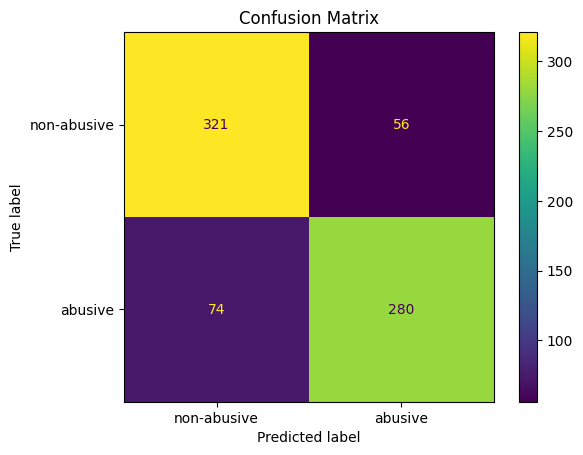


submission.csv saved


In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from xgboost import XGBClassifier


TRAIN_PATH = "/content/drive/MyDrive/data/train.csv"
TEST_PATH  = "/content/drive/MyDrive/data/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

train_df["Class"] = train_df["Class"].astype(str).str.lower().str.strip()
train_df["Text"]  = train_df["Text"].astype(str).str.strip()
test_df["Text"]   = test_df["Text"].astype(str).str.strip()

train_df = train_df[train_df["Class"].isin(["abusive", "non-abusive"])].reset_index(drop=True)

# =====================================================
# ✅ RUN-1 LABEL MAP (non-abusive=0, abusive=1)
# =====================================================
label_map = {"non-abusive": 0, "abusive": 1}
y_all = train_df["Class"].map(label_map).astype(int).values
X_all = train_df["Text"].tolist()
le_classes = ["non-abusive", "abusive"]

print("Label mapping:", label_map)
print("Check counts:", train_df["Class"].value_counts().to_dict())

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

MODEL_NAME = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 192


class ClsDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item


train_loader = DataLoader(ClsDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader   = DataLoader(ClsDataset(X_val, y_val), batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

optimizer = torch.optim.AdamW(clf.parameters(), lr=2e-5)


def eval_model(model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            preds = torch.argmax(out.logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].detach().cpu().numpy())
    return accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds, average="macro")


best_f1 = -1
best_state = None
EPOCHS = 3

for ep in range(1, EPOCHS + 1):
    clf.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = clf(**batch)
        loss = out.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_acc, val_f1 = eval_model(clf)
    print(f"Epoch {ep}: train_loss={total_loss/len(train_loader):.4f} val_acc={val_acc:.4f} val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in clf.state_dict().items()}

clf.load_state_dict(best_state)
clf.to(device)
clf.eval()


encoder = AutoModel.from_pretrained(MODEL_NAME).to(device)
encoder.load_state_dict(clf.bert.state_dict(), strict=False)
encoder.eval()


def mean_pooling(hidden_states, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
    summed = torch.sum(hidden_states * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts


@torch.no_grad()
def get_embeddings(texts, batch_size=32):
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt").to(device)
        out = encoder(**enc)

        cls  = out.last_hidden_state[:, 0, :]
        mean = mean_pooling(out.last_hidden_state, enc["attention_mask"])

        cls  = torch.nn.functional.normalize(cls, p=2, dim=1)
        mean = torch.nn.functional.normalize(mean, p=2, dim=1)

        emb = torch.cat([cls, mean], dim=1)
        vecs.append(emb.cpu().numpy())

    return np.vstack(vecs)


X_train_emb = get_embeddings(X_train)
X_val_emb   = get_embeddings(X_val)


pos = int(np.sum(y_train == 1))   # abusive count (because abusive=1)
neg = int(np.sum(y_train == 0))   # non-abusive count
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=4000,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=2.0,
    reg_alpha=0.2,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_emb, y_train)

val_prob = xgb.predict_proba(X_val_emb)[:, 1]  # prob of class=1 (abusive)

best_thr, best_f1 = 0.5, -1
for thr in np.arange(0.1, 0.91, 0.02):
    pred = (val_prob >= thr).astype(int)
    f1m = f1_score(y_val, pred, average="macro")
    if f1m > best_f1:
        best_f1, best_thr = f1m, thr

y_pred = (val_prob >= best_thr).astype(int)

acc = accuracy_score(y_val, y_pred)
f1m = f1_score(y_val, y_pred, average="macro")

print("\nFinal:")
print("best_threshold:", best_thr)
print("accuracy:", round(acc, 4))
print("macro_f1:", round(f1m, 4))
print("\nReport:\n", classification_report(y_val, y_pred, target_names=le_classes))

cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)

ConfusionMatrixDisplay(cm, display_labels=le_classes).plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


test_emb = get_embeddings(test_df["Text"].tolist())
test_prob = xgb.predict_proba(test_emb)[:, 1]
test_pred = (test_prob >= best_thr).astype(int)

# map back to labels using the same run-1 mapping
test_labels = ["abusive" if p == 1 else "non-abusive" for p in test_pred]

if "id" in test_df.columns:
    sub = pd.DataFrame({"id": test_df["id"], "Class": test_labels})
else:
    sub = pd.DataFrame({"id": range(len(test_labels)), "Class": test_labels})

sub.to_csv("submission.csv", index=False)
print("\nsubmission.csv saved")
